In [32]:
import os

# Define your folder name based on the assignment format
root_folder = "ds_MdShahzainMisbah"

# Create the required folder structure
os.makedirs(f"{root_folder}/csv_files", exist_ok=True)
os.makedirs(f"{root_folder}/outputs", exist_ok=True)

print("Folder structure created:")
!tree {root_folder}


Folder structure created:
/bin/bash: line 1: tree: command not found


In [33]:
!pip install -q gdown
import gdown

# Historical Data
hist_url = "https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs"
gdown.download(hist_url, f"{root_folder}/csv_files/historical_data.csv", quiet=False)

# Fear & Greed Index
fg_url = "https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf"
gdown.download(fg_url, f"{root_folder}/csv_files/fear_greed_index.csv", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1IAfLZwu6rJzyWKgBToqwSmmVYU6VbjVs
To: /content/ds_MdShahzainMisbah/csv_files/historical_data.csv
100%|██████████| 47.5M/47.5M [00:00<00:00, 234MB/s]
Downloading...
From: https://drive.google.com/uc?id=1PgQC0tO8XN-wqkNyghWc_-mnrYv_nhSf
To: /content/ds_MdShahzainMisbah/csv_files/fear_greed_index.csv
100%|██████████| 90.8k/90.8k [00:00<00:00, 60.0MB/s]


'ds_MdShahzainMisbah/csv_files/fear_greed_index.csv'

In [34]:
import pandas as pd

# Load datasets
fear_df = pd.read_csv(f"{root_folder}/csv_files/fear_greed_index.csv")
historical_df = pd.read_csv(f"{root_folder}/csv_files/historical_data.csv")

# Function to summarise datasets
def summarise_df(name, df):
    print(f"\n--- {name} ---")
    print(f"Shape: {df.shape}")
    print("Columns:", df.columns.tolist())
    print("\nFirst 5 rows:")
    print(df.head())
    print("\nData Types:")
    print(df.dtypes)
    print("\nMissing Values:")
    print(df.isna().sum())

# Summarise both
summarise_df("Fear & Greed Index", fear_df)
summarise_df("Historical Trader Data", historical_df)



--- Fear & Greed Index ---
Shape: (2644, 4)
Columns: ['timestamp', 'value', 'classification', 'date']

First 5 rows:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05

Data Types:
timestamp          int64
value              int64
classification    object
date              object
dtype: object

Missing Values:
timestamp         0
value             0
classification    0
date              0
dtype: int64

--- Historical Trader Data ---
Shape: (211224, 16)
Columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

First 5 rows:
                                      Account  Coin  Execution Price  

In [35]:
# ---- Fear & Greed cleaning ----
fear_df['date'] = pd.to_datetime(fear_df['date'])
fear_df['classification'] = fear_df['classification'].replace({
    'Extreme Fear': 'Fear',
    'Extreme Greed': 'Greed'
})

# ---- Historical data cleaning ----
historical_df['Timestamp IST'] = pd.to_datetime(historical_df['Timestamp IST'], format='%d-%m-%Y %H:%M')
historical_df['trade_date'] = historical_df['Timestamp IST'].dt.date  # date without time
historical_df['trade_date'] = pd.to_datetime(historical_df['trade_date'])

# Quick check
print(fear_df.head(3))
print(historical_df[['Timestamp IST', 'trade_date']].head(3))
print("\nUnique sentiment labels:", fear_df['classification'].unique())


    timestamp  value classification       date
0  1517463000     30           Fear 2018-02-01
1  1517549400     15           Fear 2018-02-02
2  1517635800     40           Fear 2018-02-03
        Timestamp IST trade_date
0 2024-12-02 22:50:00 2024-12-02
1 2024-12-02 22:50:00 2024-12-02
2 2024-12-02 22:50:00 2024-12-02

Unique sentiment labels: ['Fear' 'Neutral' 'Greed']


In [36]:
# Merge on matching dates
merged_df = historical_df.merge(
    fear_df[['date', 'classification', 'value']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

print("Merged shape:", merged_df.shape)
print("Sample merged data:")
print(merged_df[['trade_date', 'classification', 'value', 'Execution Price', 'Size USD', 'Closed PnL']].head(10))

# Check if any trades have no sentiment data
missing_sentiment = merged_df['classification'].isna().sum()
print(f"\nTrades without sentiment data: {missing_sentiment}")


Merged shape: (211224, 20)
Sample merged data:
  trade_date classification  value  Execution Price  Size USD  Closed PnL
0 2024-12-02          Greed   80.0           7.9769   7872.16         0.0
1 2024-12-02          Greed   80.0           7.9800    127.68         0.0
2 2024-12-02          Greed   80.0           7.9855   1150.63         0.0
3 2024-12-02          Greed   80.0           7.9874   1142.04         0.0
4 2024-12-02          Greed   80.0           7.9894     69.75         0.0
5 2024-12-02          Greed   80.0           7.9900     11.27         0.0
6 2024-12-02          Greed   80.0           7.9934   1151.77         0.0
7 2024-12-02          Greed   80.0           8.0000    272.00         0.0
8 2024-12-02          Greed   80.0           8.0000    368.00         0.0
9 2024-12-02          Greed   80.0           8.0000    100.00         0.0

Trades without sentiment data: 6


In [37]:
# Remove rows without sentiment
merged_df = merged_df.dropna(subset=['classification'])

# Create win/loss flag
merged_df['is_win'] = merged_df['Closed PnL'] > 0

# Aggregate daily metrics by sentiment
sentiment_stats = merged_df.groupby('classification').agg(
    avg_pnl = ('Closed PnL', 'mean'),
    median_pnl = ('Closed PnL', 'median'),
    win_rate = ('is_win', 'mean'),
    avg_trade_size_usd = ('Size USD', 'mean'),
    median_trade_size_usd = ('Size USD', 'median'),
    num_trades = ('Account', 'count')
).reset_index()

# Convert win_rate to %
sentiment_stats['win_rate'] = sentiment_stats['win_rate'] * 100

print(sentiment_stats)


  classification    avg_pnl  median_pnl   win_rate  avg_trade_size_usd  \
0           Fear  49.212077         0.0  40.787150         7182.011019   
1          Greed  53.882281         0.0  42.031120         4574.424490   
2        Neutral  34.307718         0.0  39.699093         4782.732661   

   median_trade_size_usd  num_trades  
0                749.400       83237  
1                552.200       90295  
2                547.655       37686  


/tmp/ipython-input-2477015174.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='avg_pnl', data=sentiment_stats, palette='viridis')


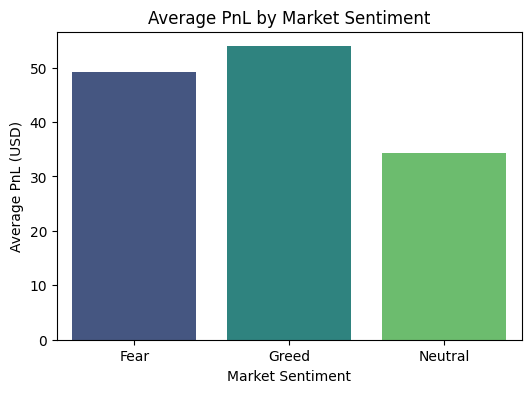

/tmp/ipython-input-2477015174.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='classification', y='win_rate', data=sentiment_stats, palette='coolwarm')


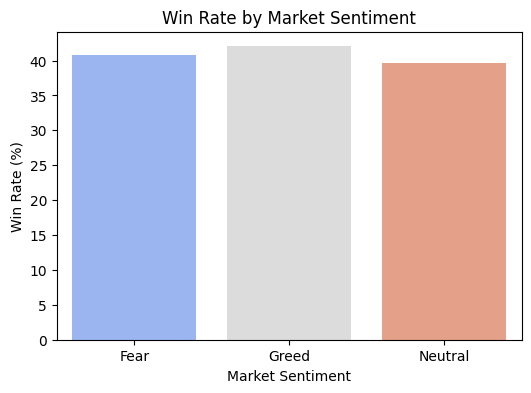

/tmp/ipython-input-2477015174.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='classification', y='Size USD', data=merged_df, palette='Set2')


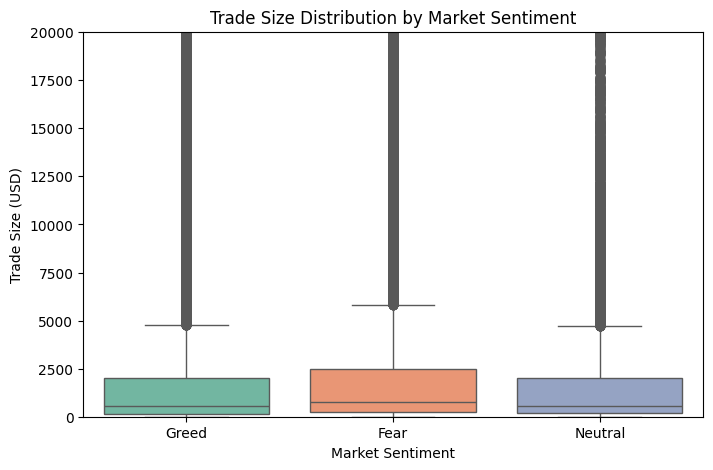

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Average PnL by sentiment
plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='avg_pnl', data=sentiment_stats, palette='viridis')
plt.title('Average PnL by Market Sentiment')
plt.ylabel('Average PnL (USD)')
plt.xlabel('Market Sentiment')
plt.savefig(f"{root_folder}/outputs/avg_pnl_by_sentiment.png")
plt.show()

# 2. Win rate by sentiment
plt.figure(figsize=(6,4))
sns.barplot(x='classification', y='win_rate', data=sentiment_stats, palette='coolwarm')
plt.title('Win Rate by Market Sentiment')
plt.ylabel('Win Rate (%)')
plt.xlabel('Market Sentiment')
plt.savefig(f"{root_folder}/outputs/win_rate_by_sentiment.png")
plt.show()

# 3. Trade size distribution
plt.figure(figsize=(8,5))
sns.boxplot(x='classification', y='Size USD', data=merged_df, palette='Set2')
plt.ylim(0, merged_df['Size USD'].quantile(0.95))  # focus on 95% range
plt.title('Trade Size Distribution by Market Sentiment')
plt.ylabel('Trade Size (USD)')
plt.xlabel('Market Sentiment')
plt.savefig(f"{root_folder}/outputs/trade_size_distribution.png")
plt.show()


Correlation between sentiment value and Closed PnL: 0.0081
Correlation between sentiment value and Trade Size USD: -0.0298


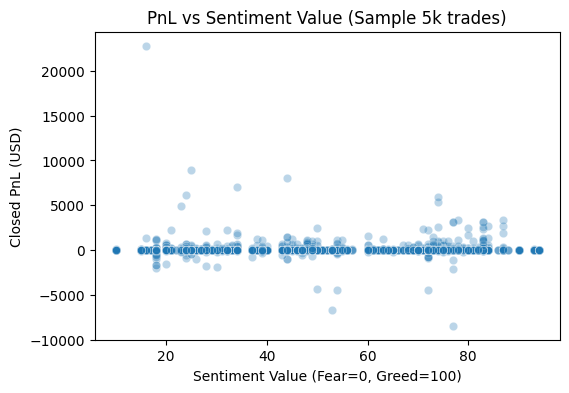

In [39]:
# Correlation between sentiment value and PnL
corr_pnl = merged_df[['value', 'Closed PnL']].corr().iloc[0,1]
corr_size = merged_df[['value', 'Size USD']].corr().iloc[0,1]

print(f"Correlation between sentiment value and Closed PnL: {corr_pnl:.4f}")
print(f"Correlation between sentiment value and Trade Size USD: {corr_size:.4f}")

# Scatter plot for PnL vs sentiment value
plt.figure(figsize=(6,4))
sns.scatterplot(x='value', y='Closed PnL', data=merged_df.sample(5000), alpha=0.3)
plt.title('PnL vs Sentiment Value (Sample 5k trades)')
plt.xlabel('Sentiment Value (Fear=0, Greed=100)')
plt.ylabel('Closed PnL (USD)')
plt.savefig(f"{root_folder}/outputs/pnl_vs_sentiment_value.png")
plt.show()


In [40]:
# Sort sentiment data by date
fear_df = fear_df.sort_values('date').reset_index(drop=True)

# Shift classification to see previous day's sentiment
fear_df['prev_classification'] = fear_df['classification'].shift(1)

# Create sentiment change column
fear_df['sentiment_shift'] = fear_df['prev_classification'] + " → " + fear_df['classification']

# Merge this shift info into trades
merged_df = merged_df.merge(
    fear_df[['date', 'sentiment_shift']],
    left_on='trade_date',
    right_on='date',
    how='left'
)

# Aggregate performance by shift type
shift_stats = merged_df.groupby('sentiment_shift').agg(
    avg_pnl = ('Closed PnL', 'mean'),
    win_rate = ('is_win', 'mean'),
    avg_trade_size_usd = ('Size USD', 'mean'),
    num_trades = ('Account', 'count')
).reset_index()

shift_stats['win_rate'] = shift_stats['win_rate'] * 100

print(shift_stats.sort_values('avg_pnl', ascending=False))


     sentiment_shift     avg_pnl   win_rate  avg_trade_size_usd  num_trades
1       Fear → Greed  165.493008  27.590314         6237.955117        2519
3       Greed → Fear  144.532692  45.676458         9467.701378        2417
4      Greed → Greed   60.047501  43.116583         4228.710726       76924
0        Fear → Fear   49.797042  40.903182         7747.786220       65391
2     Fear → Neutral   47.278627  39.252989         6173.570999       11459
6     Neutral → Fear   31.800622  39.529458         4426.089071       15429
8  Neutral → Neutral   28.769170  39.635813         2537.565606       20484
5    Greed → Neutral   28.181647  40.814905        10015.604931        5743
7    Neutral → Greed  -15.727077  37.688905         6638.859792       10852


/tmp/ipython-input-476783963.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='avg_pnl', y='sentiment_shift', data=shift_stats.sort_values('avg_pnl', ascending=False), palette='Spectral')


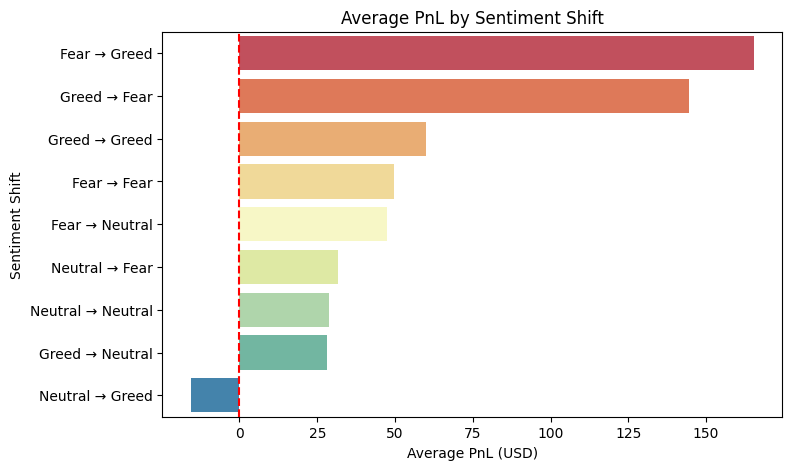

In [41]:
plt.figure(figsize=(8,5))
sns.barplot(x='avg_pnl', y='sentiment_shift', data=shift_stats.sort_values('avg_pnl', ascending=False), palette='Spectral')
plt.axvline(0, color='red', linestyle='--')
plt.title('Average PnL by Sentiment Shift')
plt.xlabel('Average PnL (USD)')
plt.ylabel('Sentiment Shift')
plt.savefig(f"{root_folder}/outputs/avg_pnl_by_sentiment_shift.png")
plt.show()


In [42]:
!pip install reportlab

In [43]:
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet

# Create PDF
doc = SimpleDocTemplate(f"{root_folder}/ds_report.pdf", pagesize=A4)
styles = getSampleStyleSheet()
elements = []

# Title
elements.append(Paragraph("<b>Trader Behavior vs Market Sentiment – Data Science Assignment</b>", styles['Title']))
elements.append(Spacer(1, 12))

# Objective
elements.append(Paragraph("<b>1. Objective</b>", styles['Heading2']))
elements.append(Paragraph(
    "The goal of this analysis was to explore the relationship between trader performance "
    "and Bitcoin market sentiment (Fear, Neutral, Greed), identify behavioral patterns, and "
    "uncover potential signals to inform smarter trading strategies."
))
elements.append(Spacer(1, 12))

# Dataset Overview
elements.append(Paragraph("<b>2. Dataset Overview</b>", styles['Heading2']))
elements.append(Paragraph(
    "Two datasets were used: (1) Bitcoin Market Sentiment (2644 rows, 2018–2024) with daily sentiment "
    "classification and index values, and (2) Historical Trader Data from Hyperliquid (211,224 trades) "
    "including trade size, execution price, PnL, and timestamps."
))
elements.append(Spacer(1, 12))

# Data Preparation
elements.append(Paragraph("<b>3. Data Preparation</b>", styles['Heading2']))
elements.append(Paragraph(
    "• Standardized date formats and merged datasets on trade date.<br/>"
    "• Normalized sentiment categories to Fear, Neutral, and Greed.<br/>"
    "• Removed 6 trades with missing sentiment data.<br/>"
    "• Created additional features including win rate, average trade size, and sentiment shift."
))
elements.append(Spacer(1, 12))

# Key Findings
elements.append(Paragraph("<b>4. Key Findings</b>", styles['Heading2']))
elements.append(Paragraph(
    "• <b>Greed days</b> had the highest average PnL (~$53.88) and win rate (42%), while "
    "<b>Fear days</b> had larger average trade sizes (~$7.18k).<br/>"
    "• <b>Neutral days</b> showed lowest profitability (~$34.31) and smallest win rates.<br/>"
    "• Sentiment <b>value</b> had negligible correlation with PnL (0.008) or trade size (-0.03), "
    "indicating sentiment level alone is not predictive.<br/>"
    "• The largest profits occurred after <b>sentiment shifts</b>, especially Fear → Greed and Greed → Fear transitions."
))
elements.append(Spacer(1, 12))

# Visual Insights
elements.append(Paragraph("<b>5. Visual Insights</b>", styles['Heading2']))
elements.append(Paragraph(
    "Key plots saved in 'outputs/' folder:<br/>"
    "• Average PnL by sentiment<br/>"
    "• Win rate by sentiment<br/>"
    "• Trade size distribution by sentiment<br/>"
    "• PnL vs sentiment value scatter plot<br/>"
    "• Average PnL by sentiment shift"
))
elements.append(Spacer(1, 12))

# Implications
elements.append(Paragraph("<b>6. Implications for Trading Strategy</b>", styles['Heading2']))
elements.append(Paragraph(
    "• Traders may achieve higher profits by paying attention to sentiment transitions rather than static sentiment levels.<br/>"
    "• Large trade sizes during Fear periods suggest elevated risk-taking behavior, potentially leading to volatility in PnL.<br/>"
    "• Neutral → Greed transitions may signal underperformance opportunities for counter-trading strategies."
))
elements.append(Spacer(1, 12))

# Conclusion
elements.append(Paragraph("<b>7. Conclusion</b>", styles['Heading2']))
elements.append(Paragraph(
    "This analysis shows that while average sentiment levels have weak correlation with trader profitability, "
    "shifts in sentiment present strong behavioral signals. Monitoring these shifts could enhance "
    "risk management and improve trade timing in volatile crypto markets."
))

# Build PDF
doc.build(elements)
print("ds_report.pdf generated and ready.")


ds_report.pdf generated and ready.


In [44]:
!zip -r ds_MdShahzainMisbah.zip ds_MdShahzainMisbah

  adding: ds_MdShahzainMisbah/ (stored 0%)
  adding: ds_MdShahzainMisbah/outputs/ (stored 0%)
  adding: ds_MdShahzainMisbah/outputs/trade_size_distribution.png (deflated 18%)
  adding: ds_MdShahzainMisbah/outputs/pnl_vs_sentiment_value.png (deflated 8%)
  adding: ds_MdShahzainMisbah/outputs/avg_pnl_by_sentiment.png (deflated 16%)
  adding: ds_MdShahzainMisbah/outputs/avg_pnl_by_sentiment_shift.png (deflated 18%)
  adding: ds_MdShahzainMisbah/outputs/win_rate_by_sentiment.png (deflated 16%)
  adding: ds_MdShahzainMisbah/ds_report.pdf (deflated 37%)
  adding: ds_MdShahzainMisbah/csv_files/ (stored 0%)
  adding: ds_MdShahzainMisbah/csv_files/fear_greed_index.csv (deflated 77%)
  adding: ds_MdShahzainMisbah/csv_files/historical_data.csv (deflated 80%)
